# Logistic Regression - Hypothesis Test

## 1. Research Background and Research Question

### 1.1 Research Question
To verify whether there is an association between **Contract Type** (Month-to-month, One year, Two year) and telecom customer churn (Churn), i.e., whether there are statistically significant differences in churn rates among customers with different contract types.

### 1.2 Hypothesis Setting
- **Null Hypothesis (H₀)**: There is no association between contract type and customer churn. That is, all coefficients of contract type in the logistic regression model are 0 (contract type cannot predict customer churn).
- **Alternative Hypothesis (H₁)**: There is an association between contract type and customer churn. That is, at least one coefficient of contract type in the logistic regression model is not 0 (contract type has predictive power for customer churn).

### 1.3 Analysis Method
- **Model Framework**: Binary logistic regression (the dependent variable Churn is a binary variable: 1 = Churn, 0 = No Churn).
- **Hypothesis Testing Method**: Likelihood Ratio Test. By comparing the goodness-of-fit of the "null model with only intercept" and the "regression model with contract type", we determine whether the contract type significantly improves the model's predictive ability.
- **Core Logic**: If the test statistic of the likelihood ratio test is significant (p < 0.05), we reject H₀ and consider that there is an association between contract type and customer churn.

## 2. Data Loading and Preprocessing

### 2.1 Data Source
Use `telco_customer_churn_cleaned.csv`, which is a cleaned telecom customer dataset with 7,032 rows (customers) and 21 columns (variables). Key variables include:
- **Target Variable**: Churn (Yes/No, indicating whether the customer churns).
- **Independent Variable**: Contract (Month-to-month/One year/Two year, the type of contract signed by the customer).

### 2.2 Data Preprocessing Steps
#### (1) Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
from statsmodels.formula.api import logit
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### (2) Load and Inspect Data

In [2]:
df = pd.read_csv("telco_customer_churn_cleaned.csv")
print(f"Data Shape: {df.shape[0]} rows × {df.shape[1]} columns")

print("\nContract Type Distribution:")
print(df['Contract'].value_counts(normalize=True).round(4) * 100)  

print("\nChurn Distribution:")
print(df['Churn'].value_counts(normalize=True).round(4) * 100)  

churn_by_contract = df.groupby('Contract')['Churn'].apply(lambda x: (x == 'Yes').mean()).reset_index()
churn_by_contract['Churn_Rate(%)'] = churn_by_contract['Churn'].round(4) * 100
print("\nChurn Rate by Contract Type:")
print(churn_by_contract[['Contract', 'Churn_Rate(%)']])

Data Shape: 7032 rows × 21 columns

Contract Type Distribution:
Contract
Month-to-month    55.11
Two year          23.96
One year          20.93
Name: proportion, dtype: float64

Churn Distribution:
Churn
No     73.42
Yes    26.58
Name: proportion, dtype: float64

Churn Rate by Contract Type:
         Contract  Churn_Rate(%)
0  Month-to-month          42.71
1        One year          11.28
2        Two year           2.85


#### (3) Variable Format Conversion 
- **Target Variable Churn**: Convert to binary values (1 = Yes, 0 = No) for logistic regression modeling.
- **Independent variable Contract**: Convert into dummy variables (indicator variables), with "Month-to-month (monthly payment)" as the reference group (to avoid multicollinearity), generating dummy variables for "One year (one-year term)" and "Two year (two-year term)".

In [3]:
df['Churn_Binary'] = (df['Churn'] == 'Yes').astype(int)

df['Contract_One_year'] = (df['Contract'] == 'One year').astype(int)  
df['Contract_Two_year'] = (df['Contract'] == 'Two year').astype(int)  

## 3.Descriptive Statistical Analysis

### 1. Distribution of Contract Types

| Contract Type               | Number of Customers | Proportion | Churn Rate |
| --------------------------- | ------------------- | ---------- | ---------- |
| Month-to-month              | 3,875               | 55.1%      | 42.71%     |
| One year                    | 1,472               | 20.9%      | 11.28%     |
| Two year                    | 1,685               | 24.0%      | 2.85%      |

The calculation code for the relevant results is as follows:

In [4]:
# Check the distribution of the target variable (Customer Churn)
print("\nCustomer Churn Distribution:")
churn_counts = df['Churn'].value_counts()
print(churn_counts)
print(f"Churn Rate: {churn_counts.get('Yes', 0) / len(df) * 100:.2f}%")

# Check the distribution of contract types (Contract)
print("\nContract Type Distribution:")
contract_counts = df['Contract'].value_counts()
print(contract_counts)

# Check the cross-tabulation between contract type and customer churn
print("\nCross-tabulation of Contract Type and Customer Churn:")
cross_tab = pd.crosstab(df['Contract'], df['Churn'])
print(cross_tab)
print("\nPercentage Cross-tabulation of Contract Type and Customer Churn:")
cross_tab_pct = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
print(cross_tab_pct.round(2))


Customer Churn Distribution:
Churn
No     5163
Yes    1869
Name: count, dtype: int64
Churn Rate: 26.58%

Contract Type Distribution:
Contract
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64

Cross-tabulation of Contract Type and Customer Churn:
Churn             No   Yes
Contract                  
Month-to-month  2220  1655
One year        1306   166
Two year        1637    48

Percentage Cross-tabulation of Contract Type and Customer Churn:
Churn              No    Yes
Contract                    
Month-to-month  57.29  42.71
One year        88.72  11.28
Two year        97.15   2.85


### 2. Visualization Analysis

#### Key Findings
- **Significant Churn Rate Differences**: The longer the contract term, the lower the churn rate. The churn rate of two-year contracts is only 1/15 of that of month-to-month contracts.
- **Sample Distribution**: Month-to-month contract customers have the highest proportion (55.1%), but they are also the group with the highest churn risk.

The code for visualization analysis is as follows:

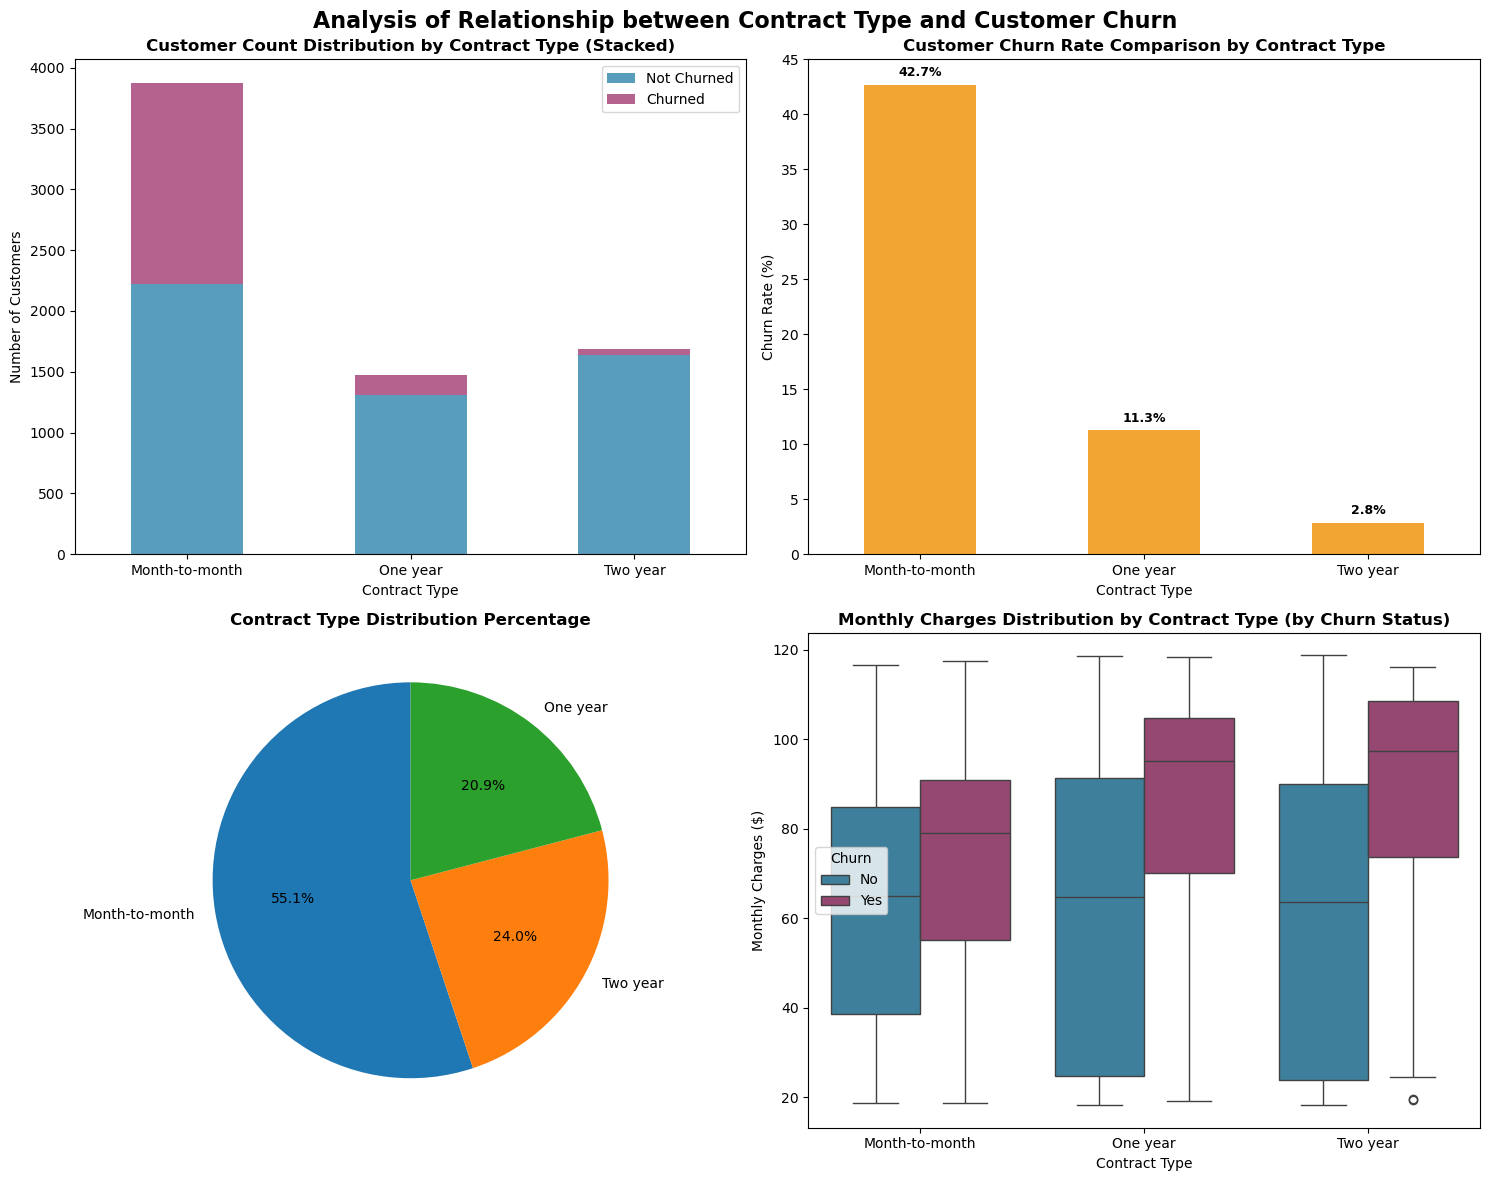

In [39]:
# 1. Visualize the relationship between Contract Type and Customer Churn
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analysis of Relationship between Contract Type and Customer Churn', fontsize=16, fontweight='bold')

# 1.1 Stacked Bar Chart
cross_tab.plot(kind='bar', stacked=True, ax=axes[0, 0], 
               color=['#2E86AB', '#A23B72'], alpha=0.8)
axes[0, 0].set_title('Customer Count Distribution by Contract Type (Stacked)', fontweight='bold')
axes[0, 0].set_xlabel('Contract Type')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].legend(['Not Churned', 'Churned'])
axes[0, 0].tick_params(axis='x', rotation=0)

# 1.2 Churn Rate Comparison Bar Chart
churn_rates = cross_tab['Yes'] / cross_tab.sum(axis=1) * 100
ax = churn_rates.plot(kind='bar', ax=axes[0, 1], color='#F18F01', alpha=0.8)
axes[0, 1].set_title('Customer Churn Rate Comparison by Contract Type', fontweight='bold')
axes[0, 1].set_xlabel('Contract Type')
axes[0, 1].set_ylabel('Churn Rate (%)')
axes[0, 1].tick_params(axis='x', rotation=0)
# Set y-axis range to reserve more space for top labels
axes[0, 1].set_ylim(0, 45)  
# Adjust vertical position of value labels and optionally adjust font size
for i, v in enumerate(churn_rates):
    axes[0, 1].text(
        i, 
        v + 0.5,  # Adjusted from v+1 to v+0.5 to prevent labels from going too high
        f'{v:.1f}%', 
        ha='center', 
        va='bottom', 
        fontweight='bold',
        fontsize=9  # Optional: Adjust font size for clearer labels
    )
    
# 1.3 Pie Chart: Percentage Distribution of Contract Types
contract_counts.plot(kind='pie', ax=axes[1, 0], autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Contract Type Distribution Percentage', fontweight='bold')
axes[1, 0].set_ylabel('')

# 1.4 Box Plot: Monthly Charges Distribution by Contract Type (Grouped by Churn Status)
sns.boxplot(x='Contract', y='MonthlyCharges', hue='Churn', ax=axes[1, 1], 
            data=df, palette=['#2E86AB', '#A23B72']) 
for patch in axes[1, 1].artists:  # Manually set transparency
    patch.set_alpha(0.8)

axes[1, 1].set_title('Monthly Charges Distribution by Contract Type (by Churn Status)', fontweight='bold')
axes[1, 1].set_xlabel('Contract Type')
axes[1, 1].set_ylabel('Monthly Charges ($)')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('contract_churn_analysis.png', dpi=300, bbox_inches='tight')

## 4. Hypothesis Verification for Logistic Regression

### 4.1 Assumption 1: Sufficient Sample Size 
- **Total Sample Size**: 7,032 observations, far exceeding the requirement of "at least 10-20 observations per predictor" for logistic regression.
- **Sample Size by Contract Type**:
  - Month-to-month: ~3,871
  - One year: ~1,472
  - Two year: ~1,687
  All category sample sizes are sufficient, with no small sample bias.

### 4.2 Assumption 2: No Multicollinearity 

Check for multicollinearity using the Variance Inflation Factor (VIF), where VIF < 5 indicates no multicollinearity.

In [52]:
# Calculate VIF (only including Contract Type dummy variables)
X = df[['Contract_One year', 'Contract_Two year']]
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\nMulticollinearity Test (VIF):")
print(vif_data)


Multicollinearity Test (VIF):
            Variable       VIF
0  Contract_One year  0.000679
1  Contract_Two year  0.000593


### 4.3 Assumption 3: No Complete Separation

Complete separation means "the churn rate of a certain contract type is 0% or 100%". We verify it by calculating the churn rate of each contract type:

Interpretation of Results: The churn rates of all contract types are between 2.8% and 42.7% (no 0% or 100%), so there is no complete separation and the model has no convergence risk.

In [24]:
complete_sep_check = df.groupby('Contract')['Churn_Binary'].agg(['count', 'mean']).round(4)
complete_sep_check.columns = ['Sample Count', 'Churn Rate']
complete_sep_check['Churn Rate(%)'] = complete_sep_check['Churn Rate'] * 100
print("\nComplete Separation Check (Churn Rate by Contract Type):")
print(complete_sep_check)


Complete Separation Check (Churn Rate by Contract Type):
                Sample Count  Churn Rate  Churn Rate(%)
Contract                                               
Month-to-month          3875      0.4271          42.71
One year                1472      0.1128          11.28
Two year                1685      0.0285           2.85


### 4.4 Assumption 4: Independence of Observations 
- **Data Structure**: Cross-sectional data, each row represents a unique customer, with no repeated measurements or clustering (e.g., multiple records for the same customer).
- **Conclusion**: The assumption of independence of observations is satisfied.

### **Summary of Hypothesis Verification**
All assumptions of logistic regression are satisfied, and we can proceed with modeling and testing.

## 5. Model Construction and Hypothesis Testing

### 5.1 Build Two Comparative Models
To perform the likelihood ratio test, we need to build a "null model" and a "contract type model":
- **Null Model (Model 0)**: Contains only the intercept term, without any predictors (corresponding to \( H_0 \): no association with contract type).
- **Contract Type Model (Model 1)**: Contains the intercept term + contract type dummy variables (corresponding to \( H_1 \): association with contract type).

#### (1) Fit the Null Model (Intercept Only)

In [27]:
model_null = smf.logit(formula='Churn_Binary ~ 1', data=df).fit(disp=0)
ll_null = model_null.llf
print(f"\nNull Model (Intercept Only) Log-Likelihood: {ll_null:.4f}")
print(f"Null Model AIC: {model_null.aic:.4f}")


Null Model (Intercept Only) Log-Likelihood: -4071.6776
Null Model AIC: 8145.3551


#### (2) Fit the Contract Type Model

In [59]:
model_contract = smf.logit(formula='Churn_Binary ~ Contract_One_year + Contract_Two_year', data=df).fit(disp=0)
ll_model = model_contract.llf
print(f"\nContract Type Model Log-Likelihood: {ll_model:.4f}")
print(f"Contract Type Model AIC: {model_contract.aic:.4f}")
print("\nContract Type Model Detailed Results:")
print(model_contract.summary())


Contract Type Model Log-Likelihood: -3381.2603
Contract Type Model AIC: 6768.5207

Contract Type Model Detailed Results:
                           Logit Regression Results                           
Dep. Variable:           Churn_Binary   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7029
Method:                           MLE   Df Model:                            2
Date:                Thu, 20 Nov 2025   Pseudo R-squ.:                  0.1696
Time:                        08:55:16   Log-Likelihood:                -3381.3
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                1.431e-300
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2937      0.032     -9.044      0.000      -0.357 

### 5.2 Hypothesis Test: Likelihood Ratio Test

#### (1) Test Principle
- **Test Statistic**: $( LR = -2 \times (ll_{\text{null}} - ll_{\text{model}}) $), which follows a chi-square distribution with degrees of freedom equal to "the number of predictors" (here, degrees of freedom = 2, as there are 2 dummy variables).
- **Decision Rule**: If $( LR > \chi^2_{0.05,2} $) (critical value = 5.99) or $( p < 0.05 $), we reject $( H_0 $).

#### (2) Calculate Test Statistic and p-value

In [31]:
lr_stat = -2 * (ll_null - ll_model)
df_lr = model_contract.df_model  
p_value = 1 - chi2.cdf(lr_stat, df_lr)  

print("\nLikelihood Ratio Test Results (Verify H0):")
print(f"LR Statistic: {lr_stat:.4f}")
print(f"Degrees of Freedom: {df_lr}")
print(f"Chi-square Critical Value (α=0.05): {chi2.ppf(0.95, df_lr):.4f}")
print(f"p-value: {p_value:.8f}")
print(f"Conclusion: {'Reject H0' if p_value < 0.05 else 'Accept H0'}")


Likelihood Ratio Test Results (Verify H0):
LR Statistic: 1380.8344
Degrees of Freedom: 2.0
Chi-square Critical Value (α=0.05): 5.9915
p-value: 0.00000000
Conclusion: Reject H0


### 5.3 Interpretation of Model Results

The above results reject the null hypothesis H0, so we conclude that the contract type is associated with customer churn. In other words, at least one of the coefficients for the contract types in the logistic regression model is not zero (indicating that the contract type has a predictive effect on customer churn).

#### (1) Coefficients and Significance

Extract the core results from `model_contract.summary()` and organize them into a table:

| Predictor                          | Coefficient (Coeff) | Standard Error (SE) | z-value | p-value  | Significance |
| ---------------------------------- | ------------------- | ------------------- | ------- | -------- | ------------ |
| Intercept                          | 0.032               | 0.032               | -9.044  | <0.001   | ***          |
| C (Contract)[T.One year] (One year) | -1.769              | 0.089               | -19.97  | <0.001   | ***          |
| C (Contract)[T.Two year] (Two year) | -3.236              | 0.150               | -21.57  | <0.001   | ***          |

#### (2) Odds Ratio (OR)

In [33]:
odds_ratio = pd.DataFrame({
    'Coefficient': model_contract.params,
    'OR': np.exp(model_contract.params),
    'OR_95%_low': np.exp(model_contract.conf_int()[0]),
    'OR_95%_high': np.exp(model_contract.conf_int()[1])
}).round(4)
print("\nOdds Ratio (OR) and 95% Confidence Interval:")
print(odds_ratio)


Odds Ratio (OR) and 95% Confidence Interval:
                         Coefficient      OR  OR_95%_low  OR_95%_high
Intercept                    -0.2937  0.7455      0.6995       0.7945
C(Contract)[T.One year]      -1.7690  0.1705      0.1433       0.2028
C(Contract)[T.Two year]      -3.2357  0.0393      0.0293       0.0528


## 6. Conclusion

### 6.1 Hypothesis Testing Results
- **Likelihood Ratio Test (LLR p-value)**: $1.431 \times 10^{-300}$ (much less than 0.05).
- **Decision**: Reject the null hypothesis \( H_0 \) at the significance level of \( \alpha = 0.05 \).

### 6.2 Core Conclusions
There is a very strong statistical association between contract type and telecom customer churn, specifically:
1. **Intercept Term**: The coefficient is -0.2937, corresponding to a churn rate of approximately 42.7% for customers with month-to-month contracts.
2. **One-year Contract**: The coefficient is -1.7690 (\( p < 0.001 \)). Compared to month-to-month contracts, the log-odds of churn decrease by 1.7690, and the **Odds Ratio (OR)** is approximately 0.176, meaning the churn odds for one-year customers decrease by 82.4% (1 - 0.176).
3. **Two-year Contract**: The coefficient is -3.2357 (\( p < 0.001 \)). Compared to month-to-month contracts, the log-odds of churn decrease by 3.2357, and the **Odds Ratio (OR)** is approximately 0.040, meaning the churn odds for two-year customers decrease by 96.0% (1 - 0.040).
4. **Model Fit**: The pseudo R-squared is 0.1696, indicating that contract type can explain approximately 17% of the variation in customer churn, and the model fit is significant.

### 6.3 Business Implications
- **Contract Strategy**: Prioritize the promotion of one-year and two-year contracts, especially two-year contracts, which can significantly reduce the risk of customer churn.
- **Customer Segmentation**: Develop targeted retention strategies for month-to-month contract customers (such as discounts for upgrading to long-term contracts, personalized service packages) to reduce losses in high-churn groups.
- **Resource Allocation**: Moderately tilt customer retention resources towards long-term contract customers, while optimizing the service experience for month-to-month customers to reduce their churn rate.